In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la
import scipy.interpolate as interp
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Multidimensional Newton-Raphson

The solution to a system of linear equations is something we will discuss next week.  For a system of non-linear equations, or really higher dimensional root finding and extremization, is a large topic.  Here we will present one, simple approach.  There are, of course, many algorithms.  The one we will use is the Newton-Raphson method which relies on knowing (or estimating) the derivatives of the functions involved.

Here we will perform a Taylor expansion in more than one dimension.  Consider a function $f(\vec y)$,

$$ f(\vec y + \Delta\vec y) = f(\vec y) + \sum_{j=1}^{n} \left. \frac{\partial f}{\partial y_j} \right|_{\Delta \vec y=0} \Delta y_j + \cdots, $$

where we have expanded about $\Delta\vec y=0$.  For a system with multiple functions, we can write in vector notation

$$ \vec f(\vec y + \Delta\vec y) = \vec f(\vec y) + \mathsf{J}_{\vec f}(\vec y) \Delta\vec y, $$

where $\mathsf{J}$ is the Jacobian matrix with components

$$ J_{ij}(\vec y) = \frac{\partial f_i(\vec y)}{\partial y_j}. $$

[*Note: the vector $\vec{f}$, which has as many components as functions, may have a different length than the vector $\vec y$, which has as many components as there are dimensions.*] If we set $\vec f(\vec y + \Delta\vec y) = 0$ we can solve to find $\Delta\vec y = - \mathsf{J}_{\vec f}^{-1}(\vec y) \vec f(\vec y)$.

The Newton-Raphson method is then to iterate on this.  Let $\vec y_n$ be a guess for the desired solution.  An improved guess is thus given by

$$ \vec y_{n+1} = \vec y_n + \Delta\vec y = \vec y_n - \mathsf{J}_{\vec f}^{-1}(\vec y_n) \vec f(\vec y_n). $$

From an initial guess, $\vec y_0$, we iteratively improve our estimate and stop when convergence has been obtained, that is, when the correction becomes sufficiently small.

**Warning:** We are going to use the algorithm as written and numerically calculate the inverse of the Jacobian matrix.  In practice this is a bad approach.  We should instead treat this as solving a system of linear equations; a topic we will cover next week.

### Jacobian Matrix

As we have seen, the Jacobian matrix is the matrix of first derivatives of the function.  Written more explicitly
$$
\mathsf{J}_{\vec f} (\vec y) = \begin{pmatrix}
\frac{\partial f_1}{\partial y_1} & \frac{\partial f_1}{\partial y_2} & \cdots \\
\frac{\partial f_2}{\partial y_1} & \frac{\partial f_2}{\partial y_2} & \cdots \\
\vdots & \vdots & \ddots
\end{pmatrix}
$$

This matrix can be calculated analytically or numerically.

### Non-linear System

As a sample for solving a non-linear system using the Newton-Raphson method consider the equations
$$
\begin{align}
16 x_1^4 + 16 x_2^4 + x_3^4 &= 16 \\
x_1^2 + x_2^2 + x_3^2 &= 3 \\
x_1^3 - x_2 &= 0
\end{align}.
$$

To evaluate this numerical we first calculate the Jacobian analytically giving
$$ \mathsf{J} =
\begin{pmatrix}
64 x_1^3 & 64 x_2^3 & 4 x_3^3 \\
2 x_1 & 2 x_2 & 2 x_3 \\
3 x_1^2 & -1 & 0
\end{pmatrix}.
$$

Next we implement the system of functions and the Jacobian as Python functions which return NumPy arrays.

In [2]:
def funcs (y) :
    """The system of non-linear equations.
    Here we assume y contains the variables (x1, x2, x3).
    We return the 3 equations in the ordered listed above in the form f(y)=0.
    """
    f = np.zeros_like(y)
    f[0] = 16*y[0]**4 + 16*y[1]**4 + y[2]**4 - 16
    f[1] = y[0]**2 + y[1]**2 + y[2]**2 - 3
    f[2] = y[0]**3 - y[1]
    return f

def Jacobian (y) :
    """Same as funcs but now returns the Jacobian."""
    J = np.zeros((len(y),len(y)))
    J[0,0] = 64*y[0]**3
    J[0,1] = 64*y[1]**3
    J[0,2] = 4*y[2]**3
    J[1,0] = 2*y[0]
    J[1,1] = 2*y[1]
    J[1,2] = 2*y[2]
    J[2,0] = 3*y[0]**2
    J[2,1] = -1
    J[2,2] = 0
    return J

To implement the Newton-Raphson method we write a function.  The method does not care what system of equations is provided.  All it needs is to know how to evalue the function and the Jacobian.  We stop when convergence is attained.  As with any routine that relies on convergence we should guard against never converging!  Thus we have a maximum number of iterations allowed.  We return the number of iterations required.  If this number is the same as the maximum then we do not know that we have converged.

The implementation thus requires a function, `f`, that returns the value of the system of equations for which we are finding the root, the Jacobian, `J`, an initial guess `y0`, and the maximum number of allowed iterations, `Nmax`.  Returned is the best guess of the root, `y`, and the number of iterations performed, `niter`.  These are returned as a tuple.

In [3]:
def newton_raphson (f, Jacobian, y0, Nmax) :
    """Solve a system of equations f(y)=0 using iteration from an initial guess,
    y0, using the Newton-Raphson method.
    At most Nmax iterations are performed.
    Both the best guess and the number of iterations are returned as a tuple."""
    # Copy y0 as our starting guess.
    y = y0.copy()
    niter = 1
    while niter <= Nmax :
        J = Jacobian(y)
        dy = np.dot(la.inv(J), f(y))
        y -= dy
        if np.allclose(np.zeros_like(dy), dy, atol=1e-10, rtol=1e-10) :
            break
        niter += 1
    return (y, niter)

As an initial guess we use all ones.

In [4]:
y0 = np.ones(3)
(y, niter) = newton_raphson(funcs, Jacobian, y0, 20)
print(f"Solution = {y} after {niter} iterations")

Solution = [0.87796576 0.67675697 1.33085541] after 6 iterations


We can verify that this really is a solutions

In [5]:
print("f(y) must be zero: f(y) =", funcs(y))

f(y) must be zero: f(y) = [0. 0. 0.]


Or instead writting a test using `assert` that will report nothing if everyting is fine and raise an error if the two arrays disagree.

In [6]:
assert(np.allclose(funcs(y), np.zeros_like(y)))

## Rational Function Interpolation

Consider the population data given in this weeks homework. As you hopefully found, different extrapolation methods could return very different results. We can take this a step further, and perform an interpolation or spline using all available data points, and attempt to extrapolate. Because higher-order polynomials diverge, we might expect this extrapolation to perform poorly.

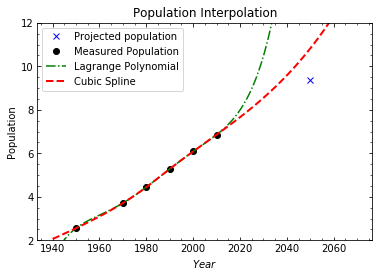

In [11]:
# Population in billions.
years = np.array([1950, 1970, 1980, 1990, 2000, 2010], dtype=np.float)
pop = np.array([2.557628654, 3.712697742, 4.444496764, 5.283252948, 6.084484918, 6.856615897 ])

i1 = interp.lagrange(years, pop)
i2 = interp.InterpolatedUnivariateSpline(years, pop)

many_years = np.linspace(1940,2070,1000)

# Now make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(0, color='k')
ax.plot([2050], [9.374484225], 'bx', label='Projected population')
ax.plot(years, pop, 'ko', label='Measured Population')
ax.plot(many_years, i1(many_years), 'g-.', label='Lagrange Polynomial')
ax.plot(many_years, i2(many_years), 'r--', lw=2, label='Cubic Spline')
ax.set_ylim(2, 12)
ax.legend(loc='best')
ax.set_xlabel(r'$Year$')
ax.set_ylabel('Population')
ax.set_title('Population Interpolation');

As expected, these estimates do not appear to agree with the projected population.

Rational functions provide us with another way to extrapolate, and give us some degree of control over the function behavior at large values. Despite this, the extrapolation is not guaranteed to perform well, and may contain poles. This is both a feature and a bug: poles in actual data can be accounted for in some instances, but poles may also appear artificially when not desired. One way of avoiding this is called Barycentric Rational Interpolation, which we will not explore here, but there is some discussion of in Numerical Recipes.

Instead, we will look into obtaining a solution for a rational function. In this case, we will need to determine the polynomial coefficients in the numerator and denominator of the function, using the data we have. In our case, we have six data points, so we will need at least six free variables. We are free to choose the polynomial order to be anything, for both the numerator and denominator,

$$ y(x) = \frac{A_0 + A_1 x + A_2 x^2 + ... }{B_0 + B_1 x + B_2 x^2 + ... }\,. $$

We can determine the polynomial coefficients $A_n$ and $B_n$ in at least several ways. The one we will focus on here is substituting in the data, and solving for the coefficients. We can multiply both sides of the above function by the denominator, and end up with a system of linear equations to solve. Ensuring that the nullity of the system is not zero, the null space of  the system will provide us with coefficients. Essentially, we want to solve a system of the form:

$$
\begin{pmatrix}
1 & x_1 & x_1^2 & \cdots & -y_1 & -x_1 y_1 & -x_1^2 y_1 & \cdots  \\
1 & x_2 & x_2^2 & \cdots & -y_2 & -x_2 y_2 & -x_2^2 y_2 & \cdots \\
\vdots & \vdots & \vdots & & \vdots & \vdots & \vdots &
\end{pmatrix}
\begin{pmatrix}
A_0 \\ A_1 \\ \vdots \\ B_0 \\ B_1 \\ \vdots 
\end{pmatrix}= 0
$$

We can, if we wish, specify additional constraints in order to fix remaining coefficients.
Below we perform this for a cubic numerator and denominator.

In [12]:
A = np.array([years**3, years**2, years**1, years**0, -pop, -pop*years, -pop*years**2, -pop*years**3]).T
ns = la.null_space(A).T
print(ns)
len(ns)

[[-2.00445864e-11  1.04744816e-07 -1.82530521e-04  1.06403413e-01
   9.94321925e-01 -1.47999957e-03  7.34550496e-07 -1.21566317e-10]
 [-1.33188028e-10  7.81124709e-07 -1.52666264e-03  9.94321854e-01
  -1.06403455e-01  1.54988469e-04 -7.51615636e-08  1.21339155e-11]]


2

So for this case, our solution is not uniquely determined, which is perhaps unsurprising since we have more variables than equations. Suppose then we wish to impose an additional constraint that the population will (eventually) equilibrate at a certain number of people, say 12 billion:

$$
\lim_{x\rightarrow \infty} y(x) = 12 = \frac{A_3}{B_3} \,.
$$

Alternatively, we could try to impose a constraint so the number of people in the infinite past was zero,

$$
\lim_{x\rightarrow -\infty} y(x) = 0 = \frac{A_3}{B_3} \,.
$$

Note the similarity of these conditions: unfortunately, the function will necessarily approach the same value at both $+\infty$ and $-\infty$. We have already run into a limitation of this approach. Changing the polynomial order will not help if we want the function to asymptote to a constant.
To see how the interpolant behaves, We can choose an appropriate combination of null space vectors to enforce this condition.

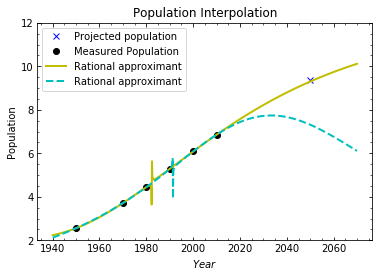

In [13]:
def P(x, nv) :
    return (nv[3] + nv[2]*x + nv[1]*x**2 + nv[0]*x**3)/(nv[4] + nv[5]*x + nv[6]*x**2 + nv[7]*x**3)

# Relative weight of null space vectors so that A_3/B_3 = 12
c_12 = (ns[0,0]-12*ns[0,7])/(12*ns[1,7]-ns[1,0])
# Relative weight of null space vectors so that A_3/B_3 = 0
c_0 = (ns[0,0]-0*ns[0,7])/(0*ns[1,7]-ns[1,0])

# Now make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(0, color='k')
ax.plot([2050], [9.374484225], 'bx', label='Projected population')
ax.plot(years, pop, 'ko', label='Measured Population')
ax.plot(many_years, P(many_years, ns[0]+c_12*ns[1]), 'y-', lw=2, label='Rational approximant')
ax.plot(many_years, P(many_years, ns[0]+c_0*ns[1]), 'c--', lw=2, label='Rational approximant')
ax.set_ylim(2, 12)
ax.legend(loc='best')
ax.set_xlabel(r'$Year$')
ax.set_ylabel('Population')
ax.set_title('Population Interpolation');

## Multidimensional interpolation

There are many situations where we need to interpolate data in multiple dimensions. In Python, and within SciPy, a fair amount of functionality exists dedicated to this problem--although specialized problems may still require specialized tools.

Interpolation of regularly spaced data is more amenable to efficient interpolation algorithms, such as bicubic interpolation in two dimensions, tricubic in three, and so on in higher dimensions. So far, scipy at least contains functionality to perform cubic interpolation only in up to two dimensions, as demonstrated below.

For now, we can consider the functionality contained within `scipy.interpolate.griddata`. This provides a fairly flexible interface, suitable for *irregularly* positioned data, at the cost of some efficiency. See also the [SciPy interpolation tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html).

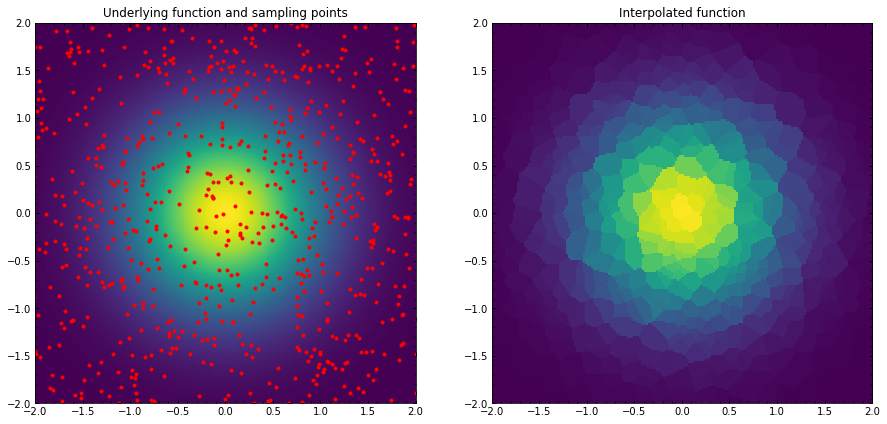

In [15]:
# Underlying 2-dimensional function we can sample
def gaussian(x, y) :
    return np.exp(-x**2-y**2)

# Grid points for interpolating at (and for plotting)
interp_x_pts, interp_y_pts = np.mgrid[-2:2:200j, -2:2:200j]

# Random gridpoints we "know" the function at
rand_pts_x = np.random.rand(1000)*5.-2.5
rand_pts_y = np.random.rand(1000)*5.-2.5
values = gaussian(rand_pts_x, rand_pts_y)

# method = 'nearest', 'linear', 'quadratic', 'cubic'
# In more than 2 dimensions, only nearest and linear currently work.
grid = interp.griddata(np.array([rand_pts_x, rand_pts_y]).T, values, (interp_x_pts, interp_y_pts), method='nearest')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(gaussian(interp_x_pts, interp_y_pts).T, extent=(-2,2,-2,2))
ax1.plot(rand_pts_x, rand_pts_y, 'r.')
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
ax1.set_title("Underlying function and sampling points")
ax2.imshow(grid, extent=(-2,2,-2,2))
ax2.set_title("Interpolated function");